In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from lassolver.utils.func import *
from lassolver.utils.signal import *
from lassolver.utils.utils import *

from lassolver.matrices.iid_gauss import iidGaussian
from lassolver.matrices.uni_invar import UniInvar

from lassolver.solver.amp import AMP
from lassolver.solver.oamp import OAMP

from lassolver.dsolver.d_amp import D_AMP
from lassolver.dsolver.d_oamp import D_OAMP

# 数値実験の設定

In [3]:
N = 4000  # 列数
alpha = 0.5  # 圧縮率
M = int(alpha*N)  # 行数
rho = 0.2  # 非零成分の割合

In [4]:
SNR = 60  # 信号対雑音比
kappa = 5  # 条件数
P = 10  # ノード数
T = 10  # 反復回数
sim = 100  # 実験数

# i.i.d.ガウス行列での信号再構成

In [5]:
MSE_tmpG = np.empty((4, sim, T+1))
CommCost_tmpG = np.empty((2, sim, T))

In [6]:
for i in tqdm(range(10)):
    iidG = iidGaussian(M, N, m=0, v=1/M)
    
    for j in tqdm(range(10)):
        x = bernouli_gaussian(N, rho)
        tmpG = [0, 0, 0, 0]
        
        tmpG[0] = AMP(iidG.A, x, SNR)
        tmpG[1] = D_AMP(iidG.A, x, SNR, P)
        tmpG[2] = OAMP(iidG.A, x, SNR, iidG=True)
        tmpG[3] = D_OAMP(iidG.A, x, SNR, P, iidG=True)

        tmpG[0].estimate(T) # AMP
        tmpG[1].estimate(T) # D-AMP
        tmpG[2].estimate(T, C=1.9, ord='LMMSE') # OAMP
        tmpG[3].estimate(T, C=1.9, ord='LMMSE') # D-OAMP
        
        n = 10*i + j
        for k in range(4):
            MSE_tmpG[k, n] = tmpG[k].mse
        for k in range(2):
            CommCost_tmpG[k, n] = tmpG[2*k+1].communication_cost

100%|██████████| 10/10 [1:34:41<00:00, 568.19s/it]


In [7]:
MSE_meanG = np.empty((4, T+1))
CommCost_meanG = np.empty((2, T))
for i in range(4):
    MSE_meanG[i] = np.mean(MSE_tmpG[i], axis=0)
for i in range(2):
    CommCost_meanG[i] = np.mean(CommCost_tmpG[i], axis=0)

In [8]:
ix1 = np.arange(0, T+1, 5)
ix2 = np.arange(0, T, 5)
it1 = np.arange(0, T+1, 1)
it2 = np.arange(0, T, 1)

## MSE (100回平均)

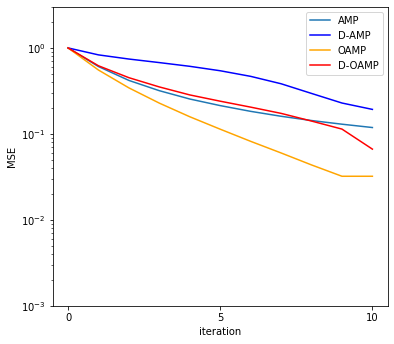

In [9]:
plt.figure(figsize=(6, 5.5))

plt.xlabel('iteration')
plt.ylabel('MSE')

plt.xticks(ix1)
plt.yscale('log')

plt.ylim(1e-3, 3e+0)

plt.plot(it1, MSE_meanG[0], label="AMP")
plt.plot(it1, MSE_meanG[1], label="D-AMP", color='blue')
plt.plot(it1, MSE_meanG[2], label="OAMP", color='orange')
plt.plot(it1, MSE_meanG[3], label="D-OAMP", color='red')

plt.legend()

In [10]:
standard = np.array([N * (P - 1) for _ in range(T)])

## 通信量 (100回平均)

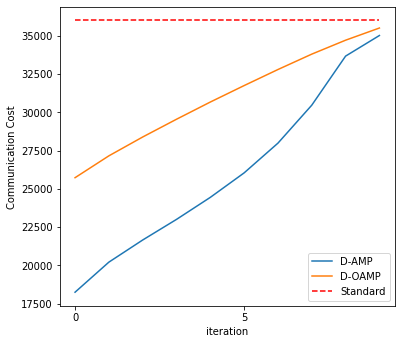

In [11]:
plt.figure(figsize=(6, 5.5))

plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, CommCost_meanG[0], label='D-AMP')
plt.plot(it2, CommCost_meanG[1], label='D-OAMP')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

# ユニタリ不変行列での信号再構成

In [12]:
MSE_tmpU = np.empty((4, sim, T+1))
CommCost_tmpU = np.empty((2, sim, T))

In [13]:
for i in tqdm(range(10)):
    UniInv = UniInvar(M, N, kappa)
    
    for j in tqdm(range(10)):
        x = bernouli_gaussian(N, rho)
        tmpU = [0, 0, 0, 0]
        
        tmpU[0] = AMP(UniInv.A, x, SNR)
        tmpU[1] = D_AMP(UniInv.A, x, SNR, P)
        tmpU[2] = OAMP(UniInv.A, x, SNR)
        tmpU[3] = D_OAMP(UniInv.A, x, SNR, P)

        tmpU[0].estimate(T) # AMP
        tmpU[1].estimate(T) # D-AMP
        tmpU[2].estimate(T, C=1.9, ord='LMMSE') # OAMP
        tmpU[3].estimate(T, C=1.9, ord='LMMSE') # D-OAMP
        
        n = 10*i + j
        for k in range(4):
            MSE_tmpU[k, n] = tmpU[k].mse
        for k in range(2):
            CommCost_tmpU[k, n] = tmpU[2*k+1].communication_cost

100%|██████████| 10/10 [4:16:16<00:00, 1537.62s/it]


In [14]:
MSE_meanU = np.empty((4, T+1))
CommCost_meanU = np.empty((2, T))
for i in range(4):
    MSE_meanU[i] = np.mean(MSE_tmpU[i], axis=0)
for i in range(2):
    CommCost_meanU[i] = np.mean(CommCost_tmpU[i], axis=0)

## MSE (100回平均)

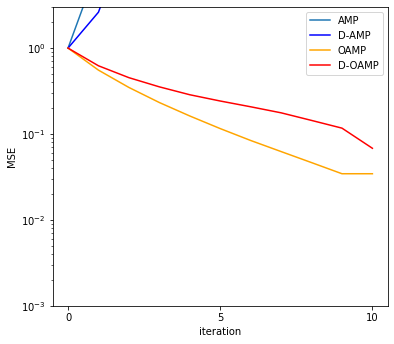

In [15]:
plt.figure(figsize=(6, 5.5))

plt.xlabel('iteration')
plt.ylabel('MSE')

plt.xticks(ix1)
plt.yscale('log')

plt.ylim(1e-3, 3e+0)

plt.plot(it1, MSE_meanU[0], label="AMP")
plt.plot(it1, MSE_meanU[1], label="D-AMP", color='blue')
plt.plot(it1, MSE_meanU[2], label="OAMP", color='orange')
plt.plot(it1, MSE_meanU[3], label="D-OAMP", color='red')

plt.legend()

## 通信量 (100回平均)

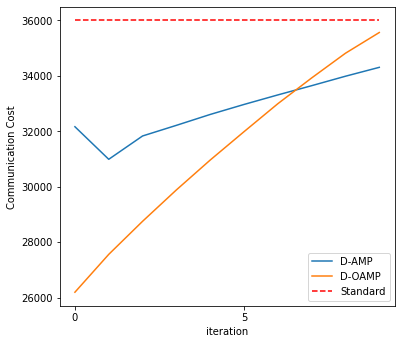

In [16]:
plt.figure(figsize=(6, 5.5))

plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, CommCost_meanU[0], label='D-AMP')
plt.plot(it2, CommCost_meanU[1], label='D-OAMP')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()